# How to Open Machine Learning Input Products

For each detectid in the line emission database (detect_hdr2.h5) we have generated 100 pixel (200 Angstrom) by 9 pixel fiber cutouts of the weighted sum of all fibers used to measured the extracton as well as cutouts of the four brightest fibers contributing to the flux. We also include the 1D spectrum (this is the same product included in the Spectra table for the detect_hdr2.h5 file) and a 30 arcsec x 30 arcsec cutout of HSC r-band imaging for the detection in available.

In [1]:
import tables as tb
import numpy as np

from astropy.table import Table, join
import astropy.units as u

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval

from hetdex_api.config import HDRconfig

In [2]:
config = HDRconfig('hdr2.1')

## Pytables and hetdex_api.config provide an easy interface to the ML products

In [3]:
fileh = tb.open_file(config.detectml, 'r') 

Here is the hierarchical structure:

In [4]:
fileh

File(filename=/data/05350/ecooper/hdr2.1/detect/detect_ml_hdr2.1.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/FiberImages (Table(1239239,)) 'Fiber Cutout Images'
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "im_wave": Float32Col(shape=(100,), dflt=0.0, pos=1),
  "im_sum": Float32Col(shape=(9, 100), dflt=0.0, pos=2),
  "im_array": Float32Col(shape=(4, 9, 100), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (56,)
  autoindex := True
  colindexes := {
    "detectid": Index(9, full, shuffle, zlib(1)).is_csi=True}
/PhotImages (Table(1239239,)) 'Photometric Images'
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "im_phot": Float32Col(shape=(60, 60), dflt=0.0, pos=1),
  "im_phot_hdr": StringCol(itemsize=2880, shape=(), dflt=b'', pos=2)}
  byteorder := 'little'
  chunkshape := (60,)
  autoindex := True
  colindexes :

# Open the 2 Summed Fiber Image

Because we have over 1 million detections in each table and each table contains several 2D arrays, the best way to navigate the file is by detectid. We have indexed all three tables based on the detectid so it is fast to query. But we do suggest you do it one by one. Please do not make copies of every component of this file on TACC anywhere on /work. Ideally you should learn to use the h5 files, otherwise pick smaller subsets of detections to work with.

In [5]:
detectid_obj = 2100208240

In [6]:
obj_data = fileh.root.FiberImages.read_where('detectid == detectid_obj')[0]

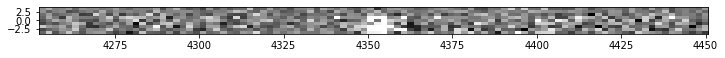

In [7]:
height=9 # in pixels
detectid = obj_data['detectid']
wave = obj_data['im_wave']
im_sum = obj_data['im_sum'] # this is the 2D summed image, 1st dim is height in fiber dims, 2nd dim is wave dim
im_array = obj_data['im_array'] # this is the 4 brightest fibers, 1st dim is fibers, 2nd dim is fiber dims, 3rd is wavelength
zscale = ZScaleInterval(contrast=0.5,krej=2.5)
vmin, vmax = zscale.get_limits(values=im_sum)
plt.figure(figsize=(12,5))
plt.imshow(im_sum,vmin=vmin, vmax=vmax,extent=[wave[0], wave[-1], -int(height/2.), int(height/2.)], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
plt.show()

# Get Single Fiber cutouts for the four brightest fibers:

The 'im_array' column consists of fiber cutouts of the 4 brightest fibers

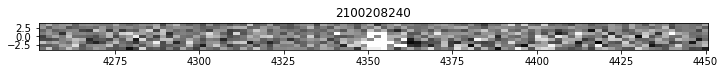

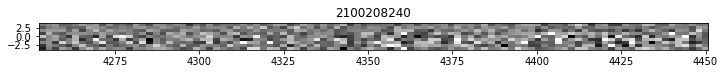

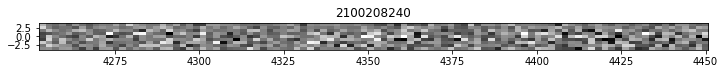

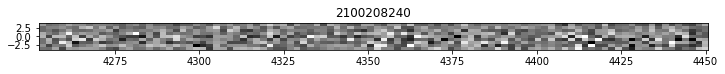

In [8]:
# plot each fiber for 4th object in example table
height=9

detectid = obj_data['detectid']
wave = obj_data['im_wave']
im_sum = obj_data['im_sum'] # this is the 2D summed image, 1st dim is height in fiber dims, 2nd dim is wave dim
im_array = obj_data['im_array'] # this is the 4 brightest fibers, 1st dim is fibers, 2nd dim is fiber dims, 3rd is wavelength
for im_i in np.arange(0,4):
    zscale = ZScaleInterval(contrast=0.5,krej=2.5)
    vmin, vmax = zscale.get_limits(values=im_array[im_i])
    plt.figure(figsize=(12,4))
    plt.title(str(detectid))
    plt.imshow(im_array[im_i],vmin=vmin, vmax=vmax,extent=[wave[0], wave[-1], -int(height/2.), int(height/2.)], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
    plt.show()

## Get the HSC 'r' band image if available

In [11]:
phot_image_table = Table(fileh.root.PhotImages.read_where('detectid == detectid_obj'))

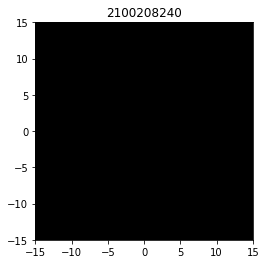

In [12]:
#Loop over the images
height=9
for row in phot_image_table:
    detectid = row['detectid']
    im_phot = row['im_phot'] # this is the r-band image
    zscale = ZScaleInterval(contrast=0.5,krej=2.5)
    vmin, vmax = zscale.get_limits(values=im_phot)
    plt.figure()
    plt.title(str(detectid))
    plt.imshow(im_phot,vmin=vmin, vmax=vmax,extent=[-15, 15, -15, 15], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
    plt.show()

## Get the Detection Spectrum

The 1D aperture Summed Spectrum is also contained in this file

In [13]:
spec_table = Table(fileh.root.Spec1D.read_where('detectid == detectid_obj'))

Text(0.5, 1.0, '2100208240')

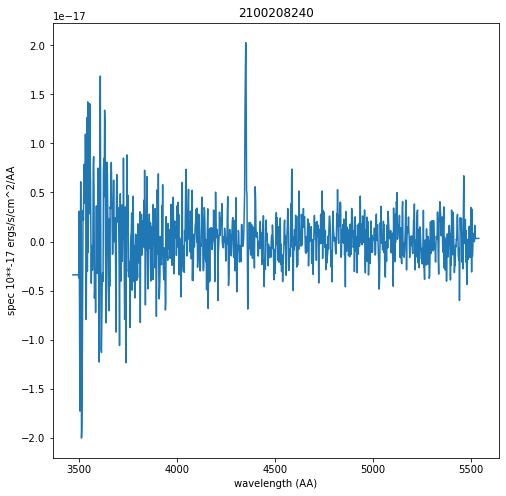

In [14]:
wave_rect = 2.0 * np.arange(1036) + 3470.0
plt.figure(figsize=(8,8))
plt.plot(wave_rect, spec_table['spec1D'][0]*10**-17 * u.erg / (u.cm ** 2 * u.s * u.AA))
plt.xlabel('wavelength (AA)')
plt.ylabel('spec 10**-17 ergs/s/cm^2/AA')
plt.title(detectid_obj)

## PLEASE CLOSE THE H5 FILE WHEN DONE

When done with an h5 file you should close it:

In [15]:
fileh.close()